check logistic to course
add simple moving averages (optionality) + bollinger etc
add drop(na) explicit
docstrings / comments
dependent variable not explicity called "log_returns", but set instead
multiple assets 
DataExplorer class


In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import yfinance as yf


In [16]:
class DataIngestor():

    def __init__(self, ticker, start, end):
        self._ticker = ticker
        self.start = start
        self.end = end
        self.get_data()
    
    def get_data(self):
        ''' retrieves (from yahoo finance) and prepares the data
        '''
        raw = yf.download(self._ticker, self.start, self.end).Close.to_frame()
        raw.rename(columns = {"Close":"price"}, inplace = True)
        self.data = raw
        

In [57]:
class PreProcessor():
    ''' Class for preparing the raw data for analysis. As a minimum it will create the dependent variable and 
    split the dataset into training and test sets.
    '''
    def __init__(self, df, train_ratio):
        self.df = df
        self.train_ratio = train_ratio
        self.log_returns()
        self.train_df, self.test_df = self.split_data()
        
    def log_returns(self):
        '''calculates log returns, our dependent variable
        '''
        self.df["log_returns"] = np.log(self.df.price/self.df.price.shift(1))
    
    def split_data(self):
        ''' splits the data into training set & test set
        '''
        full_df = self.df.copy()
        split_index = int(len(full_df) * self.train_ratio)
        split_date = full_df.index[split_index-1]
        train_start = full_df.index[0]
        test_end = full_df.index[-1]
            
        train_df = full_df.loc[train_start:split_date].copy()
        test_df = full_df.loc[split_date:test_end].copy()
        
        return train_df, test_df
   


In [119]:
class FeatureEngineer():
    ''' Class for the vectorized backtesting of Machine Learning-based trading strategies (Classification).
    '''
    def __init__(self, train_df, test_df, lags):
        self.lags = lags
        self.train_df = train_df
        self.test_df = test_df
        self.feature_columns = []
        
    def lag_returns(self):
        new_feature_columns = ["lag{}".format(lag) for lag in range(1, self.lags + 1)]
        self.feature_columns.extend(new_feature_columns)
        
        for df in [self.train_df, self.test_df]:
            for lag in range(1, self.lags + 1):
                col = "lag{}".format(lag)
                df[col] = df["log_returns"].shift(lag)
            df.dropna(inplace=True)
        
    

In [168]:
class MLBacktester():
    ''' Class for the vectorized backtesting of Machine Learning-based trading strategies (Classification).
    '''
    def __init__(self, train_df, test_df, feature_columns, tc):
        self.train_df = train_df
        self.test_df = test_df
        self.feature_columns = feature_columns
        self.tc = tc
        self.model = LogisticRegression(C = 1e6, max_iter = 100000, multi_class = "ovr")
        
    def fit_model(self):
        self.model.fit(self.train_df[self.feature_columns], np.sign(self.train_df["log_returns"]))
        
    def test_strategy(self):
        self.predict = self.model.predict(self.test_df[self.feature_columns])
        

    def check_results(self):
        self.test_df["pred"] = self.predict
        
        # calculate Strategy Returns
        self.test_df["strategy"] = self.test_df["pred"] * self.test_df["log_returns"]
        
        # determine the number of trades in each bar
        self.test_df["trades"] = self.test_df["pred"].diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        self.test_df.strategy = self.test_df.strategy - self.test_df.trades * self.tc
        
        # calculate cumulative returns for strategy & buy and hold
        self.test_df["creturns"] = self.test_df["log_returns"].cumsum().apply(np.exp)
        self.test_df["cstrategy"] = self.test_df['strategy'].cumsum().apply(np.exp)
        self.results = self.test_df
        
        perf = self.results["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - self.results["creturns"].iloc[-1] # out-/underperformance of strategy
        
        return round(perf, 6), round(outperf, 6)
        
    def plot_results(self):
        ''' Plots the performance of the trading strategy and compares to "buy and hold".
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "Logistic Regression: | TC = {}".format(self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))


In [17]:
asset = DataIngestor("EURUSD=X", "2019-01-01", "2020-08-31")

C:\Users\KaranSadhwani\github\financial-prediction-pipeline\financial-prediction-pipeline-env\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [54]:
preprocessing = PreProcessor(df, train_ratio=0.7)

433


In [65]:
train_df = preprocessing.train_df
test_df = preprocessing.test_df

In [120]:
feature_engineering = FeatureEngineer(train_df, test_df, 5)

In [121]:
feature_engineering.lag_returns()
train_df = feature_engineering.train_df

In [122]:
train_df

price  log_returns      lag1      lag2      lag3      lag4  \
Date                                                                        
2019-03-13  1.128745     0.002503  0.002384  0.003039 -0.010277  0.000611   
2019-03-14  1.133106     0.003856  0.002503  0.002384  0.003039 -0.010277   
2019-03-15  1.130838    -0.002004  0.003856  0.002503  0.002384  0.003039   
2019-03-18  1.131977     0.001007 -0.002004  0.003856  0.002503  0.002384   
2019-03-19  1.133620     0.001450  0.001007 -0.002004  0.003856  0.002503   
...              ...          ...       ...       ...       ...       ...   
2020-02-24  1.083905     0.004721 -0.002046  0.001360 -0.004132 -0.000152   
2020-02-25  1.084920     0.000936  0.004721 -0.002046  0.001360 -0.004132   
2020-02-26  1.088200     0.003018  0.000936  0.004721 -0.002046  0.001360   
2020-02-27  1.088589     0.000358  0.003018  0.000936  0.004721 -0.002046   
2020-02-28  1.099723     0.010175  0.000358  0.003018  0.000936  0.004721   

                lag5  
Date                  
2019-03-13 -0.002672  
2019-03-14  0.000611  
2019-03-15 -0.010277  
2019-03-18  0.003039  
2019-03-19  0.002384  
...              ...  
2020-02-24 -0.000390  
2020-02-25 -0.000152  
2020-02-26 -0.004132  
2020-02-27  0.001360  
2020-02-28 -0.002046  

[252 rows x 7 columns]

In [123]:
feature_columns = feature_engineering.feature_columns


['lag1', 'lag2', 'lag3', 'lag4', 'lag5']

In [174]:
mlbacktester = MLBacktester(train_df, test_df, feature_columns, 0.0000)

In [175]:
mlbacktester.fit_model()

In [176]:
mlbacktester.test_strategy()

In [177]:
mlbacktester.check_results()

(0.991845, -0.102712)

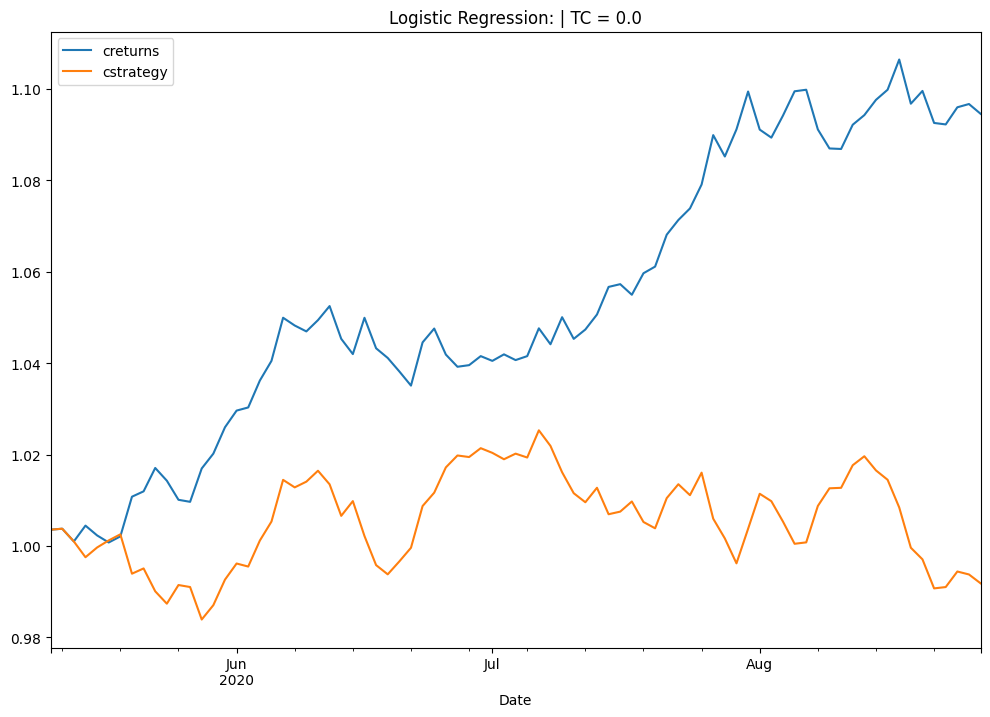

In [178]:
mlbacktester.plot_results()